In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from llm_explore.utils import get_torch_device
from llm_explore.definitions import ROOT_DIR

2025-07-05 17:56:35.997 | INFO     | llm_explore.config:<module>:11 - PROJ_ROOT path is: /Users/zeromh/ds/llm_explore


In [2]:
device = get_torch_device()
torch.mps.manual_seed(42)

Returned MPS device


In [3]:
transforms = v2.Compose([
    v2.ToImage(),  # Convert to PIL image to tensor
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=(0.2860,), std=(0.3530,)),
])

training_data = datasets.FashionMNIST(root=Path(ROOT_DIR, 'data'),
    train=True, download=True, transform=transforms)
test_data = datasets.FashionMNIST(root=Path(ROOT_DIR, 'data'),
    train=False, download=True, transform=transforms)    

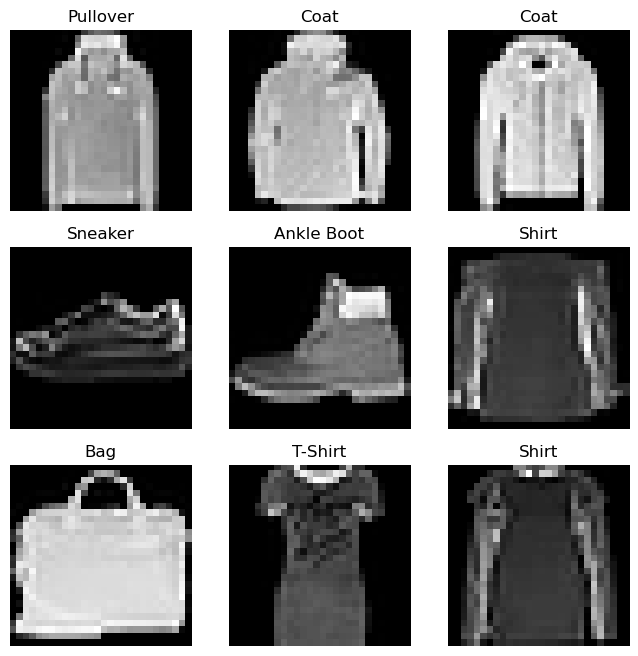

In [40]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3 # for charting 9 images
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
img, label = training_data[0]
print(img.shape, label)

In [26]:
for i, (X, y) in enumerate(train_dataloader):
    print(i, X.shape, y.shape)
    break

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [7]:
y

tensor([5, 4, 7, 0, 0, 2, 2, 7, 3, 7, 5, 1, 5, 9, 4, 5, 5, 9, 7, 6, 1, 5, 6, 2,
        9, 2, 1, 2, 2, 2, 6, 2, 3, 0, 5, 7, 0, 6, 7, 3, 0, 3, 5, 1, 7, 1, 0, 9,
        6, 6, 5, 6, 1, 2, 1, 8, 2, 3, 3, 8, 6, 2, 4, 8])

In [5]:
class MLP1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=True)
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x, y=None):
        out = self.flatten(x)
        out = self.linear1(out)
        out = self.relu(out)
        logits = self.linear2(out)
        loss = None
        if y is not None:
            loss = self.loss_fn(logits, y)
        return logits, loss
    


In [45]:
model = MLP1(input_dim=28*28, hidden_dim=512, output_dim=10)
model.to(device)

MLP1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [7]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


In [19]:
for p in model.named_parameters():
    print(p[0], p[1].shape)

linear1.weight torch.Size([512, 784])
linear1.bias torch.Size([512])
linear2.weight torch.Size([10, 512])
linear2.bias torch.Size([10])


In [ ]:
# # From copilot, not sure if correct
# class FashionMNISTModel(nn.Module):
#     def __init__(self):
#         super(FashionMNISTModel, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28 * 28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [7]:
optimizer = optim.SGD(model.named_parameters(), lr=.05)

In [44]:
train_dataloader.dataset.data.shape[0]

60000

In [52]:
num_epochs = 5
train_sample_size = train_dataloader.dataset.data.shape[0]
test_sample_size = test_dataloader.dataset.data.shape[0]
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    epoch_test_loss = 0
    for batch_idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits, loss = model(X, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(epoch_loss/train_sample_size)
    
    # Compute test loss
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            logits, loss = model(X, y)
            epoch_test_loss += loss.item()
    test_losses.append(epoch_test_loss/test_sample_size)

100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


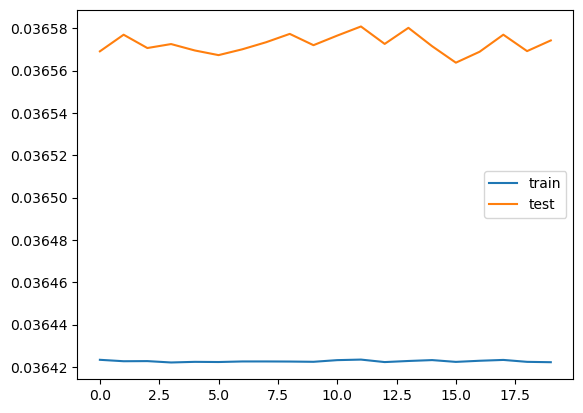

In [53]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test']);

In [54]:
# Save model
torch.save(model.state_dict(), Path(ROOT_DIR, "mlp1_fashionmnist.pth"))

# Later, to load:
# model = MLP1(input_dim=28*28, hidden_dim=512, output_dim=10)
# model.load_state_dict(torch.load(Path(ROOT_DIR, "mlp1_fashionmnist.pth")))
# model.to(device)
# model.eval()  # Set to evaluation mode if needed

In [ ]:
# When is it faster to send data to device? Does it matter for just
# computing logits/loss? 

# yingbo's base rate is .07  (relevant for baseline cross entropy). She uses base e for cross entropy tho. 
# Pytorch also uses base e for crossEntroypLoss.


# start video 1 at 1:50
# Model is not really getting better. Troubleshoot!


# Notes
# datasets.FashionMNIST does the transform on the spot when you grab the data,
# so if you look at data.data, it's untransformed. When you grab indexes,
# it's transformed.